In [ ]:

# !pip install -q scikit-learn pandas matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from google.colab import files, drive

# plotting defaults
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,5)
RANDOM_STATE = 42


In [ ]:

DATA_PATH = '/content/diabetes.csv'

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head())
print("\nColumns:", list(df.columns))


Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pedigree,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Pedigree', 'Age', 'Outcome']


In [ ]:
# For the Pima-like diabetes dataset, zeros in some columns mean missing.
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
present = [c for c in cols_with_zeros if c in df.columns]
print("Columns treated as missing-zeros ->", present)

# Replace zeros with NaN then impute medians
df[present] = df[present].replace(0, np.nan)
imputer = SimpleImputer(strategy='median')
df[present] = imputer.fit_transform(df[present])

print("After imputation — any nulls left?:", df.isnull().sum().sum())
display(df.describe().T)


Columns treated as missing-zeros -> ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
After imputation — any nulls left?: 0


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,121.656250,30.438286,44.000,99.75000,117.0000,140.25000,199.00
BloodPressure,768.0,72.386719,12.096642,24.000,64.00000,72.0000,80.00000,122.00
SkinThickness,768.0,29.108073,8.791221,7.000,25.00000,29.0000,32.00000,99.00
Insulin,768.0,140.671875,86.383060,14.000,121.50000,125.0000,127.25000,846.00
BMI,768.0,32.455208,6.875177,18.200,27.50000,32.3000,36.60000,67.10
Pedigree,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [ ]:
# ---- Cell: Use Outcome as target (run this) ----
target_col = 'Outcome'
print("Using target column:", target_col)

# ensure the column exists
if target_col not in df.columns:
    raise ValueError(f"Column '{target_col}' not found in dataframe. Columns: {df.columns.tolist()}")

X = df.drop(columns=[target_col]).values
y = df[target_col].values
print("X shape:", X.shape, "y shape:", y.shape, "unique y:", np.unique(y))


Using target column: Outcome
X shape: (768, 8) y shape: (768,) unique y: [0 1]


In [ ]:
# ---- Cell: train/test split + scaling ----
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

print("Train/test sizes:", X_train_s.shape, X_test_s.shape)


Train/test sizes: (576, 8) (192, 8)


Explained variance ratio (PCA 2): [0.29278252 0.18534339]


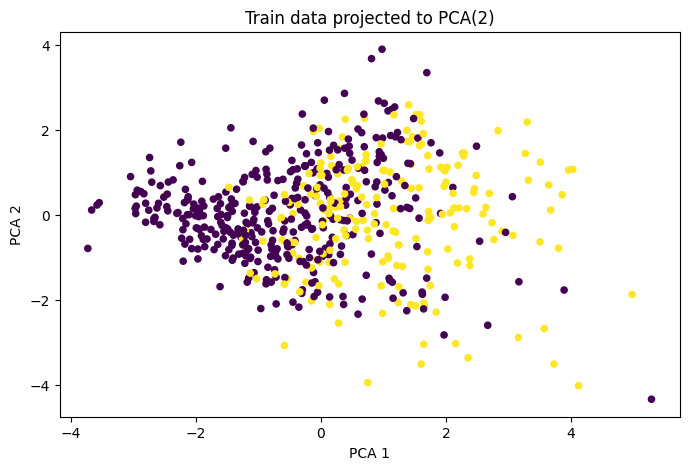

In [ ]:
# Cell 7 - (Optional) PCA -> 2D for visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_train_2d = pca.fit_transform(X_train_s)
X_test_2d = pca.transform(X_test_s)

print("Explained variance ratio (PCA 2):", pca.explained_variance_ratio_)

plt.scatter(X_train_2d[:,0], X_train_2d[:,1], c=y_train, s=20, cmap='viridis')
plt.title("Train data projected to PCA(2)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


In [ ]:
# Cell 8 - Sweep k (1..30): CV error and test error (table + save CSV)
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

ks = list(range(1, 31))
test_errors = []
cv_errors = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_s, y_train)
    pred_test = knn.predict(X_test_s)
    test_errors.append(1 - accuracy_score(y_test, pred_test))

    scores = cross_val_score(knn, X_train_s, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    cv_errors.append(1 - scores.mean())

results = pd.DataFrame({'k': ks, 'test_error': test_errors, 'cv_error': cv_errors})
display(results)
results.to_csv('knn_k_errors.csv', index=False)
print("Saved results to knn_k_errors.csv")


,k,test_error,cv_error
0,1,0.291667,0.308996
1,2,0.291667,0.295082
2,3,0.286458,0.265592
3,4,0.270833,0.279505
4,5,0.265625,0.263868
5,6,0.286458,0.253463
6,7,0.276042,0.256957
7,8,0.260417,0.251679
8,9,0.270833,0.246492
9,10,0.281250,0.241289


Saved results to knn_k_errors.csv


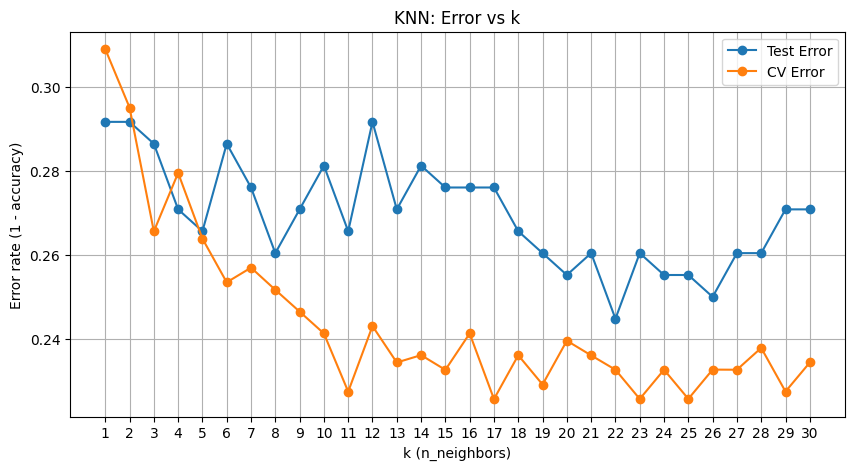

In [ ]:
# Cell 9 - Plot Error vs k
plt.figure(figsize=(10,5))
plt.plot(results['k'], results['test_error'], marker='o', label='Test Error')
plt.plot(results['k'], results['cv_error'], marker='o', label='CV Error')
plt.xticks(results['k'])
plt.xlabel('k (n_neighbors)')
plt.ylabel('Error rate (1 - accuracy)')
plt.title('KNN: Error vs k')
plt.grid(True)
plt.legend()
plt.show()


Best k by CV: 17  Best k by Test: 22


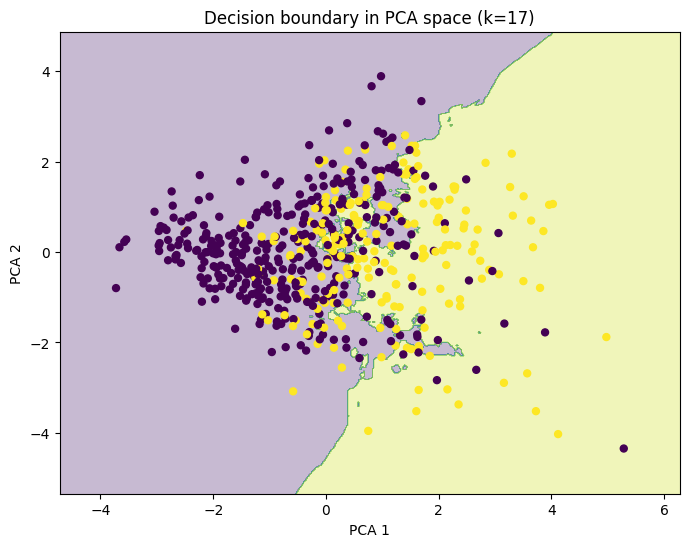

Test accuracy (PCA2 model): 0.6927083333333334


In [ ]:
# Cell 10 - Decision boundary in PCA(2) space (visual)
best_k_cv = int(results.loc[results['cv_error'].idxmin(), 'k'])
best_k_test = int(results.loc[results['test_error'].idxmin(), 'k'])
print("Best k by CV:", best_k_cv, " Best k by Test:", best_k_test)

viz_knn = KNeighborsClassifier(n_neighbors=best_k_cv)
viz_knn.fit(X_train_2d, y_train)

# Mesh grid for decision boundary
h = 0.02
x_min, x_max = X_train_2d[:,0].min() - 1, X_train_2d[:,0].max() + 1
y_min, y_max = X_train_2d[:,1].min() - 1, X_train_2d[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = viz_knn.predict(grid).reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train_2d[:,0], X_train_2d[:,1], c=y_train, s=25)
plt.title(f'Decision boundary in PCA space (k={best_k_cv})')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

print("Test accuracy (PCA2 model):", accuracy_score(y_test, viz_knn.predict(X_test_2d)))


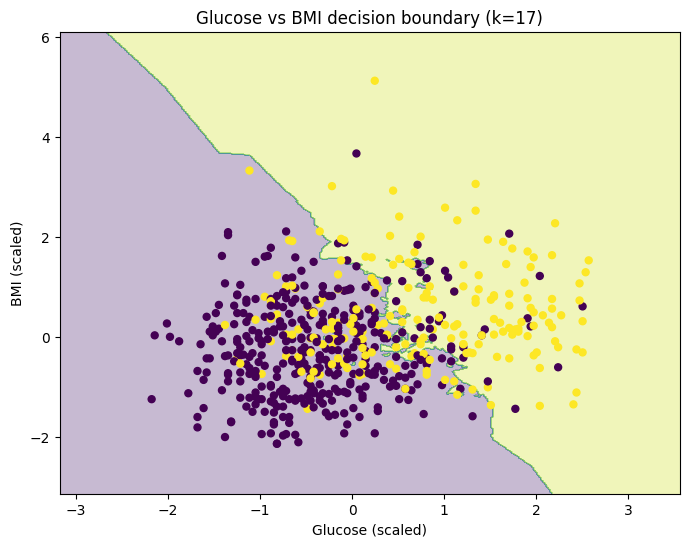

Test accuracy (2-feature KNN): 0.7135416666666666


In [ ]:
# Optional visualization: using real features Glucose vs BMI
f1, f2 = 'Glucose', 'BMI'
if f1 in df.columns and f2 in df.columns:
    X_two = df[[f1, f2]].values
    y_all = df['Outcome'].values
    X_train2, X_test2, y_train2, y_test2 = train_test_split(
        X_two, y_all, test_size=0.25, random_state=42, stratify=y_all
    )
    scaler2 = StandardScaler().fit(X_train2)
    X_train2_s = scaler2.transform(X_train2)
    X_test2_s = scaler2.transform(X_test2)

    knn2d = KNeighborsClassifier(n_neighbors=best_k_cv)
    knn2d.fit(X_train2_s, y_train2)

    # Mesh grid for boundary
    x_min2, x_max2 = X_train2_s[:,0].min()-1, X_train2_s[:,0].max()+1
    y_min2, y_max2 = X_train2_s[:,1].min()-1, X_train2_s[:,1].max()+1
    xx2, yy2 = np.meshgrid(np.arange(x_min2, x_max2, 0.02), np.arange(y_min2, y_max2, 0.02))
    grid2 = np.c_[xx2.ravel(), yy2.ravel()]
    Z2 = knn2d.predict(grid2).reshape(xx2.shape)

    plt.figure(figsize=(8,6))
    plt.contourf(xx2, yy2, Z2, alpha=0.3)
    plt.scatter(X_train2_s[:,0], X_train2_s[:,1], c=y_train2, s=25)
    plt.title(f'{f1} vs {f2} decision boundary (k={best_k_cv})')
    plt.xlabel(f'{f1} (scaled)')
    plt.ylabel(f'{f2} (scaled)')
    plt.show()

    print("Test accuracy (2-feature KNN):", accuracy_score(y_test2, knn2d.predict(X_test2_s)))
else:
    print(f"Columns {f1} or {f2} not found in dataset")


# New section